# 第4章：反向传播算法实现

> **学习目标**
> - 深入理解反向传播的核心思想和数学原理
> - 掌握链式法则在神经网络中的应用
> - 从零实现完整的反向传播算法
> - 理解梯度的计算和形状匹配
> - 实现完整的训练循环（前向+反向+参数更新）
> - 在真实数据集上训练神经网络

---

## 📚 本章内容

1. **反向传播的直觉理解**
2. **计算图与链式法则**
3. **数学推导**：单层和多层网络
4. **梯度的形状分析**
5. **从零实现反向传播**
6. **完整训练循环**：Mini-batch梯度下降
7. **实战项目**：月亮数据集训练
8. **可视化训练过程**
9. **练习题**

---

## 重要前置知识

在学习本章之前，请确保已经完成：
- ✅ **math_foundations/02_calculus.ipynb** - 链式法则和梯度
- ✅ **math_foundations/05_matrix_calculus.ipynb** - 矩阵微分
- ✅ **math_foundations/06_backpropagation_math.ipynb** - 反向传播数学推导
- ✅ **03_mlp_forward.ipynb** - 多层感知机与前向传播

---

In [1]:
# 导入必要的库
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
import warnings
warnings.filterwarnings('ignore')


# 设置随机种子，确保结果可复现
np.random.seed(42)

# 设置绘图风格
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['font.sans-serif'] = [
        'Arial Unicode MS',  # macOS通用
        'PingFang SC',       # macOS系统字体
        'STHeiti',           # 华文黑体
        'Heiti TC',          # 黑体-繁
        'SimHei',            # 黑体
    ]
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 设置随机种子
np.random.seed(42)

## 1. 反向传播的直觉理解

### 1.1 训练神经网络的本质

**问题**：如何调整权重使得预测更准确？

```
当前预测:
输入 → [网络] → 预测=0.2  真实标签=1  ❌ 错误！

我们需要知道：
- 哪些权重对这个错误影响最大？
- 应该增加还是减少这些权重？
- 改变多少才合适？

这就是梯度告诉我们的信息！
```

### 1.2 反向传播 vs 前向传播

| 阶段 | 方向 | 目的 | 计算内容 |
|------|------|------|----------|
| **前向传播** | 输入 → 输出 | 预测 | 计算每层的激活值 |
| **反向传播** | 输出 → 输入 | 学习 | 计算每层参数的梯度 |

**核心思想**：
- **前向传播**：数据流动，产生预测
- **计算损失**：比较预测与真实标签
- **反向传播**：误差反向流动，计算梯度
- **参数更新**：根据梯度调整权重

### 1.3 简单例子：单个神经元

让我们从最简单的单个神经元开始理解：

In [2]:
# 单个神经元的前向和反向传播
print("="*60)
print("单个神经元的反向传播示例")
print("="*60)

# 前向传播
x = np.array([2.0, 3.0])  # 输入
w = np.array([0.5, -0.2]) # 权重
b = 1.0                    # 偏置
y_true = 1.0               # 真实标签

# 计算
z = np.dot(w, x) + b                  # 线性：z = w^T x + b = 0.5*2 + (-0.2)*3 + 1 = 1.4
y_pred = 1 / (1 + np.exp(-z))         # Sigmoid激活
loss = 0.5 * (y_pred - y_true) ** 2   # 均方误差损失

print(f"\n前向传播：")
print(f"  输入 x = {x}")
print(f"  权重 w = {w}")
print(f"  偏置 b = {b}")
print(f"  线性输出 z = {z:.4f}")
print(f"  预测 y_pred = {y_pred:.4f}")
print(f"  真实标签 y_true = {y_true}")
print(f"  损失 L = {loss:.4f}")

# 反向传播：计算梯度
# 链式法则：dL/dw = (dL/dy_pred) * (dy_pred/dz) * (dz/dw)

# 1. 损失对预测的梯度
dL_dy_pred = y_pred - y_true  # dL/dy_pred = y_pred - y_true

# 2. 预测对线性输出的梯度（Sigmoid导数）
dy_pred_dz = y_pred * (1 - y_pred)  # sigmoid的导数

# 3. 线性输出对权重/偏置的梯度
dz_dw = x  # dz/dw = x
dz_db = 1  # dz/db = 1

# 4. 链式法则组合
dL_dz = dL_dy_pred * dy_pred_dz
dL_dw = dL_dz * dz_dw
dL_db = dL_dz * dz_db

print(f"\n反向传播（梯度计算）：")
print(f"  dL/dy_pred = {dL_dy_pred:.4f}")
print(f"  dy_pred/dz = {dy_pred_dz:.4f}")
print(f"  dL/dz = {dL_dz:.4f}")
print(f"  dL/dw = {dL_dw}")
print(f"  dL/db = {dL_db:.4f}")

# 参数更新
learning_rate = 0.1
w_new = w - learning_rate * dL_dw
b_new = b - learning_rate * dL_db

print(f"\n参数更新（学习率={learning_rate}）：")
print(f"  新权重 w = {w_new}")
print(f"  新偏置 b = {b_new:.4f}")

# 验证：使用新参数重新预测
z_new = np.dot(w_new, x) + b_new
y_pred_new = 1 / (1 + np.exp(-z_new))
loss_new = 0.5 * (y_pred_new - y_true) ** 2

print(f"\n更新后的结果：")
print(f"  新预测 y_pred = {y_pred_new:.4f} （更接近真实标签{y_true}）")
print(f"  新损失 L = {loss_new:.4f} （损失下降了{loss - loss_new:.4f}）")
print(f"\n✅ 反向传播成功让预测更准确！")

单个神经元的反向传播示例

前向传播：
  输入 x = [2. 3.]
  权重 w = [ 0.5 -0.2]
  偏置 b = 1.0
  线性输出 z = 1.4000
  预测 y_pred = 0.8022
  真实标签 y_true = 1.0
  损失 L = 0.0196

反向传播（梯度计算）：
  dL/dy_pred = -0.1978
  dy_pred/dz = 0.1587
  dL/dz = -0.0314
  dL/dw = [-0.06278086 -0.09417129]
  dL/db = -0.0314

参数更新（学习率=0.1）：
  新权重 w = [ 0.50627809 -0.19058287]
  新偏置 b = 1.0031

更新后的结果：
  新预测 y_pred = 0.8091 （更接近真实标签1.0）
  新损失 L = 0.0182 （损失下降了0.0013）

✅ 反向传播成功让预测更准确！


**关键洞察**：
1. **梯度方向**：告诉我们参数应该增加还是减少
2. **梯度大小**：告诉我们这个参数对损失的影响有多大
3. **链式法则**：将复杂的梯度计算分解为简单的步骤

---

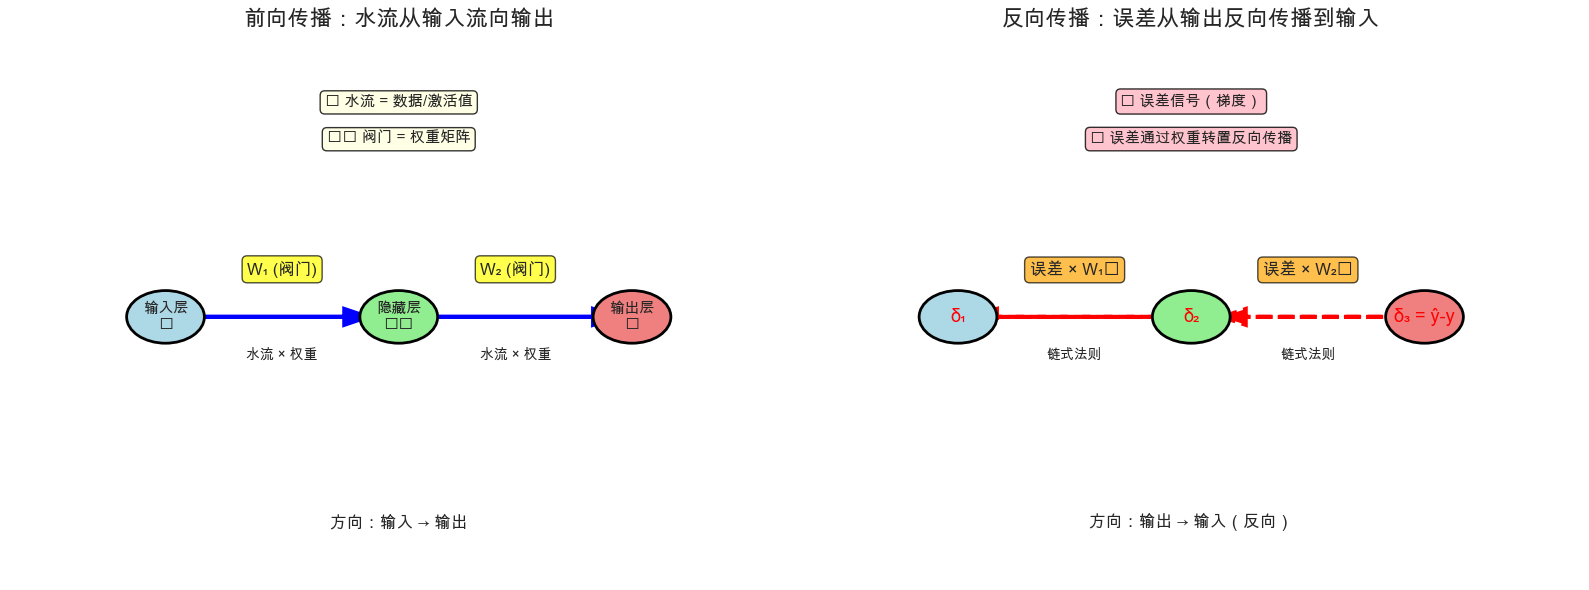


💧 水流类比总结

前向传播（Forward Propagation）：
  🌊 水从输入流向输出
  🎚️ 每个阀门（权重）调整水流大小
  💧 最终输出 = 经过所有阀门调整后的水流

反向传播（Backpropagation）：
  💢 从输出的"误差"开始
  🔙 误差沿着水管反向流动
  📊 每个阀门接收"责任信号"（梯度）
  🔧 根据责任信号调整阀门（更新权重）

关键洞察：
  1️⃣  梯度 = 责任大小
  2️⃣  链式法则 = 误差逐层传递
  3️⃣  权重更新 = 调整阀门减少误差
  4️⃣  激活函数导数 = 误差传递的衰减系数



In [3]:
# 水流类比可视化：2层网络的前向和反向传播

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# === 左图：前向传播（水流向下）===
ax1 = axes[0]
ax1.set_xlim(0, 10)
ax1.set_ylim(0, 10)
ax1.axis('off')
ax1.set_title('前向传播：水流从输入流向输出', fontsize=16, fontweight='bold', pad=20)

# 层的位置
layer_x = [2, 5, 8]
layer_names = ['输入层\n💧', '隐藏层\n💧💧', '输出层\n💧']

# 绘制层
for i, (x, name) in enumerate(zip(layer_x, layer_names)):
    # 绘制圆圈代表层
    circle = plt.Circle((x, 5), 0.5, color=['lightblue', 'lightgreen', 'lightcoral'][i], 
                        ec='black', linewidth=2, zorder=3)
    ax1.add_patch(circle)
    ax1.text(x, 5, name, ha='center', va='center', fontsize=11, fontweight='bold')
    
# 绘制箭头和权重
# 输入 → 隐藏
ax1.arrow(2.5, 5, 1.8, 0, head_width=0.3, head_length=0.3, 
          fc='blue', ec='blue', linewidth=3, zorder=2)
ax1.text(3.5, 5.8, 'W₁ (阀门)', fontsize=12, ha='center', 
         bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))
ax1.text(3.5, 4.2, '水流 × 权重', fontsize=10, ha='center', style='italic')

# 隐藏 → 输出
ax1.arrow(5.5, 5, 2.0, 0, head_width=0.3, head_length=0.3, 
          fc='blue', ec='blue', linewidth=3, zorder=2)
ax1.text(6.5, 5.8, 'W₂ (阀门)', fontsize=12, ha='center',
         bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))
ax1.text(6.5, 4.2, '水流 × 权重', fontsize=10, ha='center', style='italic')

# 添加说明
ax1.text(5, 9, '💧 水流 = 数据/激活值', fontsize=11, ha='center',
         bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))
ax1.text(5, 8.3, '🎚️ 阀门 = 权重矩阵', fontsize=11, ha='center',
         bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))
ax1.text(5, 1, '方向：输入 → 输出', fontsize=12, ha='center', fontweight='bold')

# === 右图：反向传播（误差逆流）===
ax2 = axes[1]
ax2.set_xlim(0, 10)
ax2.set_ylim(0, 10)
ax2.axis('off')
ax2.set_title('反向传播：误差从输出反向传播到输入', fontsize=16, fontweight='bold', pad=20)

# 绘制层
for i, (x, name) in enumerate(zip(layer_x, layer_names)):
    circle = plt.Circle((x, 5), 0.5, color=['lightblue', 'lightgreen', 'lightcoral'][i], 
                        ec='black', linewidth=2, zorder=3)
    ax2.add_patch(circle)
    # 改为误差符号
    error_symbols = ['δ₁', 'δ₂', 'δ₃ = ŷ-y']
    ax2.text(x, 5, error_symbols[i], ha='center', va='center', 
             fontsize=13, fontweight='bold', color='red')

# 绘制反向箭头
# 输出 → 隐藏
ax2.arrow(7.5, 5, -1.8, 0, head_width=0.3, head_length=0.3, 
          fc='red', ec='red', linewidth=3, zorder=2, linestyle='--')
ax2.text(6.5, 5.8, '误差 × W₂ᵀ', fontsize=12, ha='center',
         bbox=dict(boxstyle='round', facecolor='orange', alpha=0.7))
ax2.text(6.5, 4.2, '链式法则', fontsize=10, ha='center', style='italic')

# 隐藏 → 输入
ax2.arrow(4.5, 5, -2.0, 0, head_width=0.3, head_length=0.3, 
          fc='red', ec='red', linewidth=3, zorder=2, linestyle='--')
ax2.text(3.5, 5.8, '误差 × W₁ᵀ', fontsize=12, ha='center',
         bbox=dict(boxstyle='round', facecolor='orange', alpha=0.7))
ax2.text(3.5, 4.2, '链式法则', fontsize=10, ha='center', style='italic')

# 添加说明
ax2.text(5, 9, '💢 误差信号（梯度）', fontsize=11, ha='center',
         bbox=dict(boxstyle='round', facecolor='lightpink', alpha=0.8))
ax2.text(5, 8.3, '🔙 误差通过权重转置反向传播', fontsize=11, ha='center',
         bbox=dict(boxstyle='round', facecolor='lightpink', alpha=0.8))
ax2.text(5, 1, '方向：输出 → 输入（反向）', fontsize=12, ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("💧 水流类比总结")
print("="*70)
print("""
前向传播（Forward Propagation）：
  🌊 水从输入流向输出
  🎚️ 每个阀门（权重）调整水流大小
  💧 最终输出 = 经过所有阀门调整后的水流

反向传播（Backpropagation）：
  💢 从输出的"误差"开始
  🔙 误差沿着水管反向流动
  📊 每个阀门接收"责任信号"（梯度）
  🔧 根据责任信号调整阀门（更新权重）

关键洞察：
  1️⃣  梯度 = 责任大小
  2️⃣  链式法则 = 误差逐层传递
  3️⃣  权重更新 = 调整阀门减少误差
  4️⃣  激活函数导数 = 误差传递的衰减系数
""")

---

### 1.4 💧 水流类比：最直观的反向传播理解

**如果数学公式让你头疼，试试这个类比！**

#### 🌊 前向传播 = 水流向下

想象神经网络是一个**复杂的水管系统**：

```
输入层         隐藏层1        隐藏层2        输出层
  💧            💧💧           💧💧💧          💧
  ║            ║ ║           ║ ║ ║          ║
  ╠═══════╗    ║ ║           ║ ║ ║          ║
  ║       ║    ║ ║           ║ ║ ║          ║
水源 ──→ [阀门W1] ──→ [阀门W2] ──→ [阀门W3] ──→ 输出水量
         (权重)      (权重)      (权重)
```

- **水流** = 数据/信号
- **阀门（权重）** = 控制水流大小
- **激活函数** = 过滤器（ReLU让负值变0，像单向阀）
- **输出** = 最终水量

**前向传播过程**：
1. 水从输入层流出
2. 经过每个阀门（权重），流量被调整
3. 经过过滤器（激活函数），流量被变换
4. 最终到达输出层

---

#### 🔄 反向传播 = 水流逆向追踪责任

现在，**输出水量不对**（损失很大）！我们需要知道：
- **哪些阀门需要调整？**
- **往哪个方向调整（开大还是关小）？**
- **调整多少？**

**反向传播就是从输出倒推回去，追踪责任！**

```
                   ┌─ 误差信号（梯度）
                   ↓
输出层 ──反向──→ 隐藏层2 ──反向──→ 隐藏层1 ──反向──→ 输入层
 💢                💢💢              💢💢💢
 
每个阀门都会收到"责任信号"：
- "你对这个错误负多少责任？"
- "你应该开大还是关小？"
```

**反向传播的3个关键步骤**：

##### 步骤1️⃣：计算输出层的误差

```
预测水量 vs 期望水量
↓
误差 = 预测 - 真实
```

这是"责任源头"，从这里开始倒推。

##### 步骤2️⃣：误差反向流动（链式法则）

```
第L层误差 ──[通过权重W_{L}传播]──→ 第L-1层误差
                     ↓
               乘以激活函数导数
               （相当于"衰减系数"）
```

**关键公式（用水流理解）**：
$$
\text{前一层的误差} = \underbrace{(\text{权重}^T \times \text{当前层误差})}_{\text{误差倒流}} \odot \underbrace{\text{激活函数导数}}_{\text{水流衰减系数}}
$$

**类比解释**：
- **权重的转置** = 水管的倒向
- **乘以误差** = 误差沿着水管倒流
- **激活函数导数** = 过滤器对倒流的衰减作用
  - ReLU导数 = 1（正向流过）或 0（负向被堵）
  - Sigmoid导数 = 小（水流衰减很大）

##### 步骤3️⃣：计算每个阀门的责任（梯度）

对于权重 $W^{(l)}$（某个阀门）：

$$
\text{阀门的责任} = \text{当前层误差} \times \text{前一层水流量}
$$

**物理意义**：
- 如果**误差大** + **水流量大** → 这个阀门责任很大！
- 如果**误差大** + **水流量小** → 这个阀门责任较小
- 如果**误差小** → 无论水流量多大，责任都小

---

#### 📊 水流类比图示

让我们用一个具体例子可视化：

## 2. 计算图与链式法则

### 2.1 计算图（Computational Graph）

计算图是反向传播的核心工具。它将复杂计算分解为简单操作的组合。

**示例：$f(x, y) = (x + y) * (x - y)$**

```
前向传播（计算值）：
  x=3, y=2
     ↓
  a = x + y = 5
  b = x - y = 1
     ↓
  f = a * b = 5

计算图：
  x ──┬─→ [+] ─→ a ─┐
      │             ↓
      │           [×] ─→ f
      │             ↑
  y ──┼─→ [-] ─→ b ─┘
      │
```

**反向传播（计算梯度）：**

```
  df/df = 1  (从输出开始)
     ↓
  df/da = df/df * ∂f/∂a = 1 * b = 1
  df/db = df/df * ∂f/∂b = 1 * a = 5
     ↓
  df/dx = df/da * ∂a/∂x + df/db * ∂b/∂x = 1*1 + 5*1 = 6
  df/dy = df/da * ∂a/∂y + df/db * ∂b/∂y = 1*1 + 5*(-1) = -4
```

### 2.2 链式法则（Chain Rule）

**标量链式法则**：
$$
\frac{dz}{dx} = \frac{dz}{dy} \cdot \frac{dy}{dx}
$$

**多路径链式法则**：
$$
\frac{\partial z}{\partial x} = \sum_{i} \frac{\partial z}{\partial y_i} \cdot \frac{\partial y_i}{\partial x}
$$

### 2.3 神经网络的计算图

对于一个3层网络：

```
前向传播：
  x → [W1, b1] → z1 → [σ] → h1 → [W2, b2] → z2 → [σ] → y → [L] → Loss

反向传播（从右到左）：
  dL/dW2 ← dL/dz2 ← dL/dy ← dL/dLoss = 1
     ↑        ↑
  dL/dh1   dL/dW1 ← dL/dz1
```

---

## 3. 数学推导：反向传播公式

### 3.1 符号定义（回顾）

对于第 $l$ 层：
- $W^{(l)}$: 权重矩阵
- $\mathbf{b}^{(l)}$: 偏置向量
- $\mathbf{z}^{(l)} = W^{(l)} \mathbf{h}^{(l-1)} + \mathbf{b}^{(l)}$: 线性输出
- $\mathbf{h}^{(l)} = \sigma(\mathbf{z}^{(l)})$: 激活输出
- $\mathbf{h}^{(0)} = \mathbf{x}$: 输入

### 3.2 输出层梯度（第L层）

**损失函数**（交叉熵 + Softmax）：
$$
L = -\sum_{k} y_k \log(\hat{y}_k)
$$

**输出层的误差项**（神奇的简化！）：
$$
\delta^{(L)} = \frac{\partial L}{\partial \mathbf{z}^{(L)}} = \hat{\mathbf{y}} - \mathbf{y}
$$

这个简化来自：交叉熵损失 + Softmax的导数相互抵消

**权重和偏置的梯度**：
$$
\begin{align}
\frac{\partial L}{\partial W^{(L)}} &= \delta^{(L)} (\mathbf{h}^{(L-1)})^T \quad \text{shape: } (n_L, n_{L-1}) \\
\frac{\partial L}{\partial \mathbf{b}^{(L)}} &= \delta^{(L)} \quad \text{shape: } (n_L,)
\end{align}
$$

### 3.3 隐藏层梯度（第l层，l < L）

**误差项递推公式**（核心！）：
$$
\delta^{(l)} = \frac{\partial L}{\partial \mathbf{z}^{(l)}} = \left( (W^{(l+1)})^T \delta^{(l+1)} \right) \odot \sigma'(\mathbf{z}^{(l)})
$$

其中：
- $(W^{(l+1)})^T \delta^{(l+1)}$: 将下一层的误差"传播"回来
- $\odot$: 逐元素乘法（Hadamard积）
- $\sigma'(\mathbf{z}^{(l)})$: 激活函数的导数

**权重和偏置的梯度**：
$$
\begin{align}
\frac{\partial L}{\partial W^{(l)}} &= \delta^{(l)} (\mathbf{h}^{(l-1)})^T \\
\frac{\partial L}{\partial \mathbf{b}^{(l)}} &= \delta^{(l)}
\end{align}
$$

### 3.4 批量数据的反向传播

对于批量数据 $X \in \mathbb{R}^{m \times n}$（$m$ 个样本）：

**输出层**：
$$
\Delta^{(L)} = \hat{Y} - Y \quad \text{shape: } (m, n_L)
$$

**隐藏层**：
$$
\Delta^{(l)} = \left( \Delta^{(l+1)} W^{(l+1)} \right) \odot \sigma'(Z^{(l)}) \quad \text{shape: } (m, n_l)
$$

**梯度（平均）**：
$$
\begin{align}
\frac{\partial L}{\partial W^{(l)}} &= \frac{1}{m} \Delta^{(l)T} H^{(l-1)} \quad \text{shape: } (n_l, n_{l-1}) \\
\frac{\partial L}{\partial \mathbf{b}^{(l)}} &= \frac{1}{m} \sum_{i=1}^{m} \delta_i^{(l)} \quad \text{shape: } (n_l,)
\end{align}
$$

---

## 4. 梯度的形状分析

### 4.1 为什么要关注形状？

**梯度的形状必须与参数的形状完全一致！**

- 权重 $W^{(l)}$ 的形状：$(n_l, n_{l-1})$
- 梯度 $\frac{\partial L}{\partial W^{(l)}}$ 的形状：必须是 $(n_l, n_{l-1})$

### 4.2 形状推导示例

假设网络结构：**输入(2) → 隐藏(4) → 输出(3)**

批量大小：$m = 10$

#### 前向传播形状：

```python
X:     (10, 2)   # 输入
W1:    (4, 2)    # 第1层权重
b1:    (4,)      # 第1层偏置
Z1:    (10, 4)   # Z1 = X @ W1.T + b1
H1:    (10, 4)   # H1 = relu(Z1)

W2:    (3, 4)    # 第2层权重
b2:    (3,)      # 第2层偏置
Z2:    (10, 3)   # Z2 = H1 @ W2.T + b2
Y:     (10, 3)   # Y = softmax(Z2)
```

#### 反向传播形状：

```python
# 输出层
dZ2 = Y - Y_true          # (10, 3)
dW2 = dZ2.T @ H1 / m      # (3, 10) @ (10, 4) = (3, 4) ✅
db2 = mean(dZ2, axis=0)   # (3,) ✅

# 隐藏层
dH1 = dZ2 @ W2            # (10, 3) @ (3, 4) = (10, 4)
dZ1 = dH1 * relu'(Z1)     # (10, 4) ⊙ (10, 4) = (10, 4)
dW1 = dZ1.T @ X / m       # (4, 10) @ (10, 2) = (4, 2) ✅
db1 = mean(dZ1, axis=0)   # (4,) ✅
```

**关键技巧**：
- 权重梯度：$\nabla_{W^{(l)}} = \delta^{(l)T} H^{(l-1)}$
- 偏置梯度：$\nabla_{\mathbf{b}^{(l)}} = \text{mean}(\delta^{(l)}, \text{axis}=0)$

---

## 5. 从零实现反向传播

### 5.1 激活函数及其导数

In [ ]:
# 激活函数
def sigmoid(z):
    """Sigmoid激活函数"""
    return 1 / (1 + np.exp(-np.clip(z, -500, 500)))

def sigmoid_derivative(z):
    """
    Sigmoid的导数
    σ'(z) = σ(z) * (1 - σ(z))
    """
    s = sigmoid(z)
    return s * (1 - s)

def relu(z):
    """ReLU激活函数"""
    return np.maximum(0, z)

def relu_derivative(z):
    """
    ReLU的导数
    ReLU'(z) = 1 if z > 0 else 0
    """
    return (z > 0).astype(float)

def tanh(z):
    """Tanh激活函数"""
    return np.tanh(z)

def tanh_derivative(z):
    """
    Tanh的导数
    tanh'(z) = 1 - tanh(z)^2
    """
    t = np.tanh(z)
    return 1 - t**2

def softmax(z):
    """Softmax激活函数"""
    if z.ndim == 1:
        z_shifted = z - np.max(z)
        exp_z = np.exp(z_shifted)
        return exp_z / np.sum(exp_z)
    else:
        z_shifted = z - np.max(z, axis=1, keepdims=True)
        exp_z = np.exp(z_shifted)
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

### 5.2 损失函数

In [ ]:
def cross_entropy_loss(y_pred, y_true):
    """
    交叉熵损失函数
    
    参数:
        y_pred: 预测概率, shape (n_samples, n_classes)
        y_true: 真实标签（one-hot编码）, shape (n_samples, n_classes)
    
    返回:
        loss: 平均损失（标量）
    """
    m = y_pred.shape[0]
    # 避免log(0)
    epsilon = 1e-8
    y_pred_clipped = np.clip(y_pred, epsilon, 1 - epsilon)
    
    # 计算交叉熵
    loss = -np.sum(y_true * np.log(y_pred_clipped)) / m
    return loss

def one_hot_encode(y, n_classes):
    """
    将类别标签转换为one-hot编码
    
    参数:
        y: 类别标签, shape (n_samples,)
        n_classes: 类别总数
    
    返回:
        one_hot: shape (n_samples, n_classes)
    
    示例:
        y = [0, 1, 2]
        one_hot_encode(y, 3) = [[1, 0, 0],
                                [0, 1, 0],
                                [0, 0, 1]]
    """
    m = len(y)
    one_hot = np.zeros((m, n_classes))
    one_hot[np.arange(m), y] = 1
    return one_hot

In [ ]:
class MLPWithBackprop_Decomposed(MLPWithBackprop):
    """
    分解版MLP - 将backward()分解成多个易于理解的子函数
    
    继承自MLPWithBackprop，只重写backward相关方法
    """
    
    def compute_output_layer_error(self, y_pred, y_true):
        """
        步骤1：计算输出层的误差
        
        对于交叉熵损失 + Softmax激活，误差简化为：
        delta^(L) = y_pred - y_true
        
        参数:
            y_pred: 预测概率, shape (m, n_output)
            y_true: 真实标签（one-hot）, shape (m, n_output)
        
        返回:
            delta: 输出层误差, shape (m, n_output)
        """
        delta = y_pred - y_true
        
        print(f"  [步骤1] 输出层误差 delta^(L) 形状: {delta.shape}")
        print(f"         误差范围: [{delta.min():.4f}, {delta.max():.4f}]")
        
        return delta
    
    def propagate_error_backward(self, delta_next, weights_next, z_current):
        """
        步骤2：将误差反向传播到前一层
        
        公式：
        delta^(l) = (delta^(l+1) @ W^(l+1)) ⊙ σ'(z^(l))
        
        参数:
            delta_next: 下一层（l+1）的误差, shape (m, n_{l+1})
            weights_next: 下一层的权重 W^(l+1), shape (n_{l+1}, n_l)
            z_current: 当前层的线性输出 z^(l), shape (m, n_l)
        
        返回:
            delta_current: 当前层的误差, shape (m, n_l)
        """
        # 2.1 误差通过权重反向传播
        # delta_next @ W_next: (m, n_{l+1}) @ (n_{l+1}, n_l) = (m, n_l)
        delta_backprop = delta_next @ weights_next
        
        # 2.2 乘以激活函数的导数（逐元素乘法）
        activation_derivative = self.activation_derivative(z_current)
        delta_current = delta_backprop * activation_derivative
        
        print(f"         误差反向传播: {delta_next.shape} → {delta_current.shape}")
        print(f"         激活函数导数范围: [{activation_derivative.min():.4f}, {activation_derivative.max():.4f}]")
        
        return delta_current
    
    def compute_layer_gradients(self, delta, activations_prev):
        """
        步骤3：计算当前层参数的梯度
        
        公式：
        ∂L/∂W^(l) = delta^(l)^T @ h^(l-1) / m
        ∂L/∂b^(l) = mean(delta^(l), axis=0)
        
        参数:
            delta: 当前层误差, shape (m, n_l)
            activations_prev: 前一层激活值, shape (m, n_{l-1})
        
        返回:
            grad_W: 权重梯度, shape (n_l, n_{l-1})
            grad_b: 偏置梯度, shape (n_l,)
        """
        m = delta.shape[0]  # 样本数
        
        # 3.1 权重梯度：delta^T @ activations_prev
        grad_W = delta.T @ activations_prev / m
        
        # 3.2 偏置梯度：对所有样本取平均
        grad_b = np.mean(delta, axis=0)
        
        print(f"         权重梯度 dW 形状: {grad_W.shape}")
        print(f"         偏置梯度 db 形状: {grad_b.shape}")
        
        return grad_W, grad_b
    
    def backward(self, X, y_true):
        """
        反向传播（分解版 - 带详细输出）
        
        使用上面定义的3个子函数，逐步计算梯度
        """
        print("\n" + "="*70)
        print("🔄 反向传播分解演示")
        print("="*70)
        
        m = X.shape[0]
        n_layers = len(self.weights)
        
        grad_weights = [None] * n_layers
        grad_biases = [None] * n_layers
        
        # === 步骤1：输出层梯度 ===
        print("\n[步骤1] 计算输出层误差")
        print("-"*70)
        
        delta = self.compute_output_layer_error(self.activations[-1], y_true)
        
        # 计算输出层参数的梯度
        print("\n[步骤3] 计算输出层参数梯度")
        print("-"*70)
        grad_weights[-1], grad_biases[-1] = self.compute_layer_gradients(
            delta, self.activations[-2]
        )
        
        # === 步骤2：逐层反向传播 ===
        print("\n[步骤2] 误差反向传播到隐藏层")
        print("-"*70)
        
        for l in range(n_layers - 2, -1, -1):
            print(f"\n  处理第 {l} 层:")
            
            # 2.1 将误差反向传播
            delta = self.propagate_error_backward(
                delta_next=delta,
                weights_next=self.weights[l + 1],
                z_current=self.z_values[l]
            )
            
            # 2.2 计算当前层参数的梯度
            print(f"\n[步骤3] 计算第 {l} 层参数梯度")
            grad_weights[l], grad_biases[l] = self.compute_layer_gradients(
                delta, self.activations[l]
            )
        
        print("\n" + "="*70)
        print("✅ 反向传播完成！")
        print("="*70)
        
        return grad_weights, grad_biases


# === 测试分解版反向传播 ===

print("\n🧪 测试分解版反向传播")
print("="*70)

# 创建小网络和数据
X_demo = np.array([[0.5, 1.5], [2.0, -1.0], [1.0, 0.5]])
y_demo = np.array([0, 1, 0])

mlp_decomposed = MLPWithBackprop_Decomposed(
    layer_sizes=[2, 4, 2],
    activation='relu',
    learning_rate=0.1,
    random_state=42
)

# 前向传播
y_one_hot = one_hot_encode(y_demo, 2)
y_pred = mlp_decomposed.forward(X_demo)

# 分解版反向传播（带详细输出）
grad_w, grad_b = mlp_decomposed.backward(X_demo, y_one_hot)

print("\n" + "💡"*30)
print("关键理解：")
print("-"*70)
print("1️⃣  输出层误差 = 预测 - 真实（交叉熵+Softmax的特殊简化）")
print("2️⃣  误差反向传播 = 误差×权重 ⊙ 激活函数导数")
print("3️⃣  参数梯度 = 误差 × 前一层激活值（矩阵乘法）")
print("4️⃣  从输出层开始，逐层向输入层传播")
print("="*70)

---

### 5.3.1 🔧 分解版：理解backward()的每一步

**问题**：上面的`backward()`方法一次做了很多事情，初学者可能难以理解。

**解决**：让我们将反向传播分解成更小的、易于理解的子函数！

#### 反向传播的3个核心步骤

```
步骤1️⃣：计算输出层梯度
    ↓
步骤2️⃣：误差反向传播（逐层）
    ↓
步骤3️⃣：计算每层参数的梯度
```

让我们逐个实现：

#### 🎓 梯度检验的最佳实践

**何时使用梯度检验？**
- ✅ **开发阶段**：实现新的网络层或激活函数后
- ✅ **调试阶段**：训练不收敛，怀疑梯度计算有问题
- ✅ **学习阶段**：理解反向传播的正确性

**何时不使用梯度检验？**
- ❌ **生产训练**：太慢，只用于验证，不用于实际训练
- ❌ **每次训练**：确认梯度正确后就不需要每次都检验

**常见的反向传播错误**：
1. **形状不匹配**：梯度形状与参数不一致
2. **转置错误**：忘记转置权重矩阵
3. **激活函数导数错误**：导数公式写错
4. **链式法则错误**：误差传播方向错误

**小技巧**：
- 使用小网络、小数据集测试（快速）
- 只抽样检查部分参数（节省时间）
- 保存梯度检验通过的模型代码（作为参考）

---

In [ ]:
def gradient_check(model, X, y, epsilon=1e-7, check_layers=[0], verbose=True):
    """
    梯度检验：比较解析梯度和数值梯度
    
    参数:
        model: MLPWithBackprop实例
        X: 输入数据, shape (n_samples, n_features)
        y: 真实标签, shape (n_samples,)
        epsilon: 数值梯度的步长
        check_layers: 要检查的层索引列表（默认只检查第0层以节省时间）
        verbose: 是否打印详细信息
    
    返回:
        results: dict, 包含每层权重和偏置的相对误差
    """
    print("\n" + "="*70)
    print("🔍 梯度检验开始")
    print("="*70)
    
    # 准备数据
    n_classes = model.layer_sizes[-1]
    y_one_hot = one_hot_encode(y, n_classes)
    
    # 1. 前向传播 + 反向传播得到解析梯度
    y_pred = model.forward(X)
    grad_weights_analytic, grad_biases_analytic = model.backward(X, y_one_hot)
    
    # 计算当前损失
    def compute_loss():
        """计算当前模型的损失"""
        y_pred = model.forward(X)
        return cross_entropy_loss(y_pred, y_one_hot)
    
    results = {}
    
    # 2. 对每一层进行检验
    for layer_idx in check_layers:
        if verbose:
            print(f"\n--- 检验第 {layer_idx} 层 ---")
        
        # === 检验权重梯度 ===
        W = model.weights[layer_idx]
        grad_W_analytic = grad_weights_analytic[layer_idx]
        grad_W_numeric = np.zeros_like(W)
        
        # 对权重矩阵的每个元素计算数值梯度
        # 注意：这里只抽样检查部分元素以节省时间
        sample_size = min(10, W.size)  # 最多检查10个元素
        indices = np.random.choice(W.size, sample_size, replace=False)
        
        if verbose:
            print(f"  权重矩阵 W{layer_idx} 形状: {W.shape}")
            print(f"  抽样检查 {sample_size} 个元素")
        
        for idx in indices:
            i, j = np.unravel_index(idx, W.shape)
            
            # 保存原始值
            original_value = W[i, j]
            
            # W[i,j] + epsilon
            W[i, j] = original_value + epsilon
            loss_plus = compute_loss()
            
            # W[i,j] - epsilon
            W[i, j] = original_value - epsilon
            loss_minus = compute_loss()
            
            # 恢复原始值
            W[i, j] = original_value
            
            # 数值梯度（双边差分）
            grad_W_numeric[i, j] = (loss_plus - loss_minus) / (2 * epsilon)
        
        # 计算权重梯度的相对误差（只对抽样的元素）
        grad_W_analytic_flat = grad_W_analytic.ravel()[indices]
        grad_W_numeric_flat = grad_W_numeric.ravel()[indices]
        
        numerator = np.linalg.norm(grad_W_analytic_flat - grad_W_numeric_flat)
        denominator = np.linalg.norm(grad_W_analytic_flat) + np.linalg.norm(grad_W_numeric_flat)
        relative_error_W = numerator / (denominator + 1e-8)
        
        results[f'layer_{layer_idx}_W'] = relative_error_W
        
        if verbose:
            print(f"  解析梯度样本: {grad_W_analytic_flat[:3]}")
            print(f"  数值梯度样本: {grad_W_numeric_flat[:3]}")
            print(f"  ✅ 权重相对误差: {relative_error_W:.2e}")
        
        # === 检验偏置梯度 ===
        b = model.biases[layer_idx]
        grad_b_analytic = grad_biases_analytic[layer_idx]
        grad_b_numeric = np.zeros_like(b)
        
        # 对偏置的每个元素计算数值梯度
        sample_size_b = min(5, b.size)
        indices_b = np.random.choice(b.size, sample_size_b, replace=False)
        
        if verbose:
            print(f"\n  偏置向量 b{layer_idx} 形状: {b.shape}")
            print(f"  抽样检查 {sample_size_b} 个元素")
        
        for idx in indices_b:
            original_value = b[idx]
            
            b[idx] = original_value + epsilon
            loss_plus = compute_loss()
            
            b[idx] = original_value - epsilon
            loss_minus = compute_loss()
            
            b[idx] = original_value
            
            grad_b_numeric[idx] = (loss_plus - loss_minus) / (2 * epsilon)
        
        # 计算偏置梯度的相对误差
        grad_b_analytic_sampled = grad_b_analytic[indices_b]
        grad_b_numeric_sampled = grad_b_numeric[indices_b]
        
        numerator = np.linalg.norm(grad_b_analytic_sampled - grad_b_numeric_sampled)
        denominator = np.linalg.norm(grad_b_analytic_sampled) + np.linalg.norm(grad_b_numeric_sampled)
        relative_error_b = numerator / (denominator + 1e-8)
        
        results[f'layer_{layer_idx}_b'] = relative_error_b
        
        if verbose:
            print(f"  解析梯度样本: {grad_b_analytic_sampled}")
            print(f"  数值梯度样本: {grad_b_numeric_sampled}")
            print(f"  ✅ 偏置相对误差: {relative_error_b:.2e}")
    
    # 3. 总结
    print("\n" + "="*70)
    print("📊 梯度检验结果总结")
    print("="*70)
    
    all_errors = list(results.values())
    max_error = max(all_errors)
    
    for key, error in results.items():
        status = "✅ 完美" if error < 1e-7 else \
                 "✅ 通过" if error < 1e-5 else \
                 "⚠️  警告" if error < 1e-3 else "❌ 错误"
        print(f"  {key}: {error:.2e}  {status}")
    
    print(f"\n  最大相对误差: {max_error:.2e}")
    
    if max_error < 1e-5:
        print("\n  🎉 恭喜！反向传播实现正确！")
    elif max_error < 1e-3:
        print("\n  ⚠️  相对误差较大，请检查反向传播实现")
    else:
        print("\n  ❌ 反向传播实现有错误，请仔细检查！")
    
    print("="*70)
    
    return results


# === 测试梯度检验 ===

print("🧪 测试梯度检验功能")
print("-"*70)

# 创建一个小网络和小数据集（快速测试）
X_test_grad = np.random.randn(5, 2)
y_test_grad = np.array([0, 1, 0, 1, 0])

mlp_test = MLPWithBackprop(
    layer_sizes=[2, 4, 2],
    activation='relu',
    learning_rate=0.01,
    random_state=42
)

# 执行梯度检验（检查第0层和第1层）
results = gradient_check(
    mlp_test, 
    X_test_grad, 
    y_test_grad, 
    epsilon=1e-7,
    check_layers=[0, 1],  # 检查两层
    verbose=True
)

---

### 5.4 🔍 梯度检验（Gradient Checking）

**问题**：我们怎么知道反向传播实现得对不对？

**答案**：用**数值梯度**验证**解析梯度**！

#### 什么是梯度检验？

**两种计算梯度的方法**：

| 方法 | 原理 | 优点 | 缺点 |
|------|------|------|------|
| **解析梯度** | 用链式法则推导公式 | 快速、精确 | 容易出错 |
| **数值梯度** | 用导数定义直接计算 | 简单、可靠 | 慢、近似 |

**梯度检验策略**：
1. 实现反向传播（解析梯度）
2. 用数值方法计算梯度
3. 比较两者是否接近
4. 如果差异很小（< 1e-5），说明实现正确！

#### 数值梯度的计算

根据导数的定义：
$$
\frac{\partial L}{\partial \theta} \approx \frac{L(\theta + \epsilon) - L(\theta - \epsilon)}{2\epsilon}
$$

其中 $\epsilon$ 是一个很小的值（如 $10^{-7}$）。

**双边差分 vs 单边差分**：

```
单边差分：[f(x+ε) - f(x)] / ε
          误差 O(ε)

双边差分：[f(x+ε) - f(x-ε)] / (2ε)
          误差 O(ε²) ✅ 更准确！
```

#### 相对误差的计算

$$
\text{relative\_error} = \frac{\|\text{grad\_analytic} - \text{grad\_numeric}\|}{\|\text{grad\_analytic}\| + \|\text{grad\_numeric}\|}
$$

**判断标准**：
- relative_error < 1e-7：完美！✅
- 1e-7 < relative_error < 1e-5：通常可接受 ✅  
- 1e-5 < relative_error < 1e-3：可能有问题，需检查 ⚠️
- relative_error > 1e-3：肯定有错误！❌

---

### 5.3 完整的MLP类（带反向传播）

In [ ]:
class MLPWithBackprop:
    """
    多层感知机（支持训练）
    
    实现了完整的前向传播、反向传播和参数更新。
    
    参数:
        layer_sizes: list, 每层神经元数量 [n_input, n_hidden1, ..., n_output]
        activation: str, 隐藏层激活函数 ('sigmoid', 'relu', 'tanh')
        learning_rate: float, 学习率
        random_state: int, 随机种子
    """
    
    def __init__(self, layer_sizes, activation='relu', 
                 learning_rate=0.01, random_state=42):
        self.layer_sizes = layer_sizes
        self.activation_name = activation
        self.learning_rate = learning_rate
        self.random_state = random_state
        
        # 选择激活函数及其导数
        activations = {
            'sigmoid': (sigmoid, sigmoid_derivative),
            'relu': (relu, relu_derivative),
            'tanh': (tanh, tanh_derivative)
        }
        self.activation, self.activation_derivative = activations[activation]
        
        # 初始化参数
        self._initialize_parameters()
        
        # 存储训练历史
        self.loss_history = []
        self.accuracy_history = []
    
    def _initialize_parameters(self):
        """初始化权重和偏置"""
        np.random.seed(self.random_state)
        
        self.weights = []
        self.biases = []
        
        for i in range(len(self.layer_sizes) - 1):
            n_in = self.layer_sizes[i]
            n_out = self.layer_sizes[i + 1]
            
            # He初始化（适用于ReLU）
            if self.activation_name == 'relu':
                std = np.sqrt(2.0 / n_in)
            else:
                std = np.sqrt(1.0 / n_in)
            
            W = np.random.randn(n_out, n_in) * std
            b = np.zeros(n_out)
            
            self.weights.append(W)
            self.biases.append(b)
    
    def forward(self, X):
        """
        前向传播
        
        参数:
            X: 输入数据, shape (n_samples, n_features)
        
        返回:
            output: 网络输出, shape (n_samples, n_output)
        """
        # 存储中间值（供反向传播使用）
        self.activations = [X]
        self.z_values = []
        
        A = X
        
        # 隐藏层
        for i in range(len(self.weights) - 1):
            Z = A @ self.weights[i].T + self.biases[i]
            A = self.activation(Z)
            
            self.z_values.append(Z)
            self.activations.append(A)
        
        # 输出层（Softmax）
        Z = A @ self.weights[-1].T + self.biases[-1]
        output = softmax(Z)
        
        self.z_values.append(Z)
        self.activations.append(output)
        
        return output
    
    def backward(self, X, y_true):
        """
        反向传播
        
        参数:
            X: 输入数据, shape (n_samples, n_features)
            y_true: 真实标签（one-hot编码）, shape (n_samples, n_classes)
        
        返回:
            grad_weights: list of arrays, 每层权重的梯度
            grad_biases: list of arrays, 每层偏置的梯度
        """
        m = X.shape[0]  # 样本数量
        n_layers = len(self.weights)
        
        grad_weights = [None] * n_layers
        grad_biases = [None] * n_layers
        
        # ===== 输出层梯度 =====
        # 对于交叉熵+Softmax，梯度简化为 y_pred - y_true
        delta = self.activations[-1] - y_true  # shape: (m, n_output)
        
        # 输出层权重和偏置的梯度
        grad_weights[-1] = delta.T @ self.activations[-2] / m  # (n_output, n_hidden)
        grad_biases[-1] = np.mean(delta, axis=0)                # (n_output,)
        
        # ===== 隐藏层梯度（从后向前） =====
        for l in range(n_layers - 2, -1, -1):
            # 1. 将误差反向传播到前一层
            #    delta_prev = (delta @ W^(l+1)) ⊙ σ'(z^(l))
            delta = (delta @ self.weights[l + 1]) * self.activation_derivative(self.z_values[l])
            # shape: (m, n_l)
            
            # 2. 计算当前层的权重和偏置梯度
            grad_weights[l] = delta.T @ self.activations[l] / m  # (n_l, n_{l-1})
            grad_biases[l] = np.mean(delta, axis=0)              # (n_l,)
        
        return grad_weights, grad_biases
    
    def update_parameters(self, grad_weights, grad_biases):
        """
        更新参数（梯度下降）
        
        参数:
            grad_weights: list of arrays, 权重梯度
            grad_biases: list of arrays, 偏置梯度
        """
        for i in range(len(self.weights)):
            self.weights[i] -= self.learning_rate * grad_weights[i]
            self.biases[i] -= self.learning_rate * grad_biases[i]
    
    def train_step(self, X, y):
        """
        一次训练步骤（前向+反向+更新）
        
        参数:
            X: 输入数据, shape (n_samples, n_features)
            y: 真实标签, shape (n_samples,)
        
        返回:
            loss: 当前损失
            accuracy: 当前准确率
        """
        # One-hot编码
        n_classes = self.layer_sizes[-1]
        y_one_hot = one_hot_encode(y, n_classes)
        
        # 1. 前向传播
        y_pred = self.forward(X)
        
        # 2. 计算损失和准确率
        loss = cross_entropy_loss(y_pred, y_one_hot)
        predictions = np.argmax(y_pred, axis=1)
        accuracy = np.mean(predictions == y)
        
        # 3. 反向传播
        grad_weights, grad_biases = self.backward(X, y_one_hot)
        
        # 4. 更新参数
        self.update_parameters(grad_weights, grad_biases)
        
        return loss, accuracy
    
    def fit(self, X, y, epochs=100, batch_size=32, 
            X_val=None, y_val=None, verbose=True):
        """
        训练网络
        
        参数:
            X: 训练数据, shape (n_samples, n_features)
            y: 训练标签, shape (n_samples,)
            epochs: 训练轮数
            batch_size: 批量大小
            X_val: 验证数据（可选）
            y_val: 验证标签（可选）
            verbose: 是否打印训练信息
        """
        n_samples = X.shape[0]
        n_batches = int(np.ceil(n_samples / batch_size))
        
        for epoch in range(epochs):
            # 打乱数据
            indices = np.random.permutation(n_samples)
            X_shuffled = X[indices]
            y_shuffled = y[indices]
            
            # Mini-batch训练
            epoch_loss = 0
            epoch_accuracy = 0
            
            for batch in range(n_batches):
                start = batch * batch_size
                end = min(start + batch_size, n_samples)
                
                X_batch = X_shuffled[start:end]
                y_batch = y_shuffled[start:end]
                
                loss, accuracy = self.train_step(X_batch, y_batch)
                epoch_loss += loss
                epoch_accuracy += accuracy
            
            # 平均损失和准确率
            epoch_loss /= n_batches
            epoch_accuracy /= n_batches
            
            self.loss_history.append(epoch_loss)
            self.accuracy_history.append(epoch_accuracy)
            
            # 打印训练信息
            if verbose and (epoch + 1) % 10 == 0:
                msg = f"Epoch {epoch+1}/{epochs} - Loss: {epoch_loss:.4f}, Acc: {epoch_accuracy:.4f}"
                
                # 如果提供了验证集，计算验证集性能
                if X_val is not None and y_val is not None:
                    val_pred = self.predict(X_val)
                    val_accuracy = np.mean(val_pred == y_val)
                    msg += f", Val Acc: {val_accuracy:.4f}"
                
                print(msg)
    
    def predict(self, X):
        """
        预测类别
        
        参数:
            X: 输入数据, shape (n_samples, n_features)
        
        返回:
            predictions: 预测的类别标签, shape (n_samples,)
        """
        output = self.forward(X)
        return np.argmax(output, axis=1)

---

## 6. 实战项目：月亮数据集训练

现在让我们用真实数据训练我们的神经网络！

In [ ]:
print("="*60)
print("实战项目：训练神经网络解决月亮数据集分类")
print("="*60)

# 1. 数据准备
X, y = make_moons(n_samples=1000, noise=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 标准化
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(f"\n数据集信息：")
print(f"  训练集: {X_train.shape}")
print(f"  测试集: {X_test.shape}")

# 2. 创建网络
print("\n" + "-"*60)
print("构建神经网络: [2, 16, 8, 2]")
print("-"*60)

mlp = MLPWithBackprop(
    layer_sizes=[2, 16, 8, 2],
    activation='relu',
    learning_rate=0.1,
    random_state=42
)

# 3. 训练
print("\n" + "-"*60)
print("开始训练...")
print("-"*60)

mlp.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    X_val=X_test,
    y_val=y_test,
    verbose=True
)

# 4. 评估
print("\n" + "="*60)
print("最终评估")
print("="*60)

train_pred = mlp.predict(X_train)
test_pred = mlp.predict(X_test)

train_acc = accuracy_score(y_train, train_pred)
test_acc = accuracy_score(y_test, test_pred)

print(f"\n训练集准确率: {train_acc:.4f}")
print(f"测试集准确率: {test_acc:.4f}")

print("\n混淆矩阵（测试集）：")
print(confusion_matrix(y_test, test_pred))

### 6.1 可视化训练过程

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 损失曲线
axes[0].plot(mlp.loss_history, linewidth=2, color='red')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('训练损失曲线', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# 准确率曲线
axes[1].plot(mlp.accuracy_history, linewidth=2, color='blue')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_title('训练准确率曲线', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n观察：")
print("- 损失逐渐下降并趋于稳定")
print("- 准确率逐渐上升并收敛")
print("- 这表明网络成功学习了数据的模式！")

### 6.2 可视化决策边界

In [ ]:
def plot_decision_boundary_trained(model, X, y, title):
    """
    绘制训练后的决策边界
    """
    # 创建网格
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))
    
    # 预测
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # 绘制
    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap='RdYlBu', levels=1)
    plt.scatter(X[y == 0, 0], X[y == 0, 1], c='blue', s=50, 
                label='类别0', edgecolors='k', alpha=0.7)
    plt.scatter(X[y == 1, 0], X[y == 1, 1], c='red', s=50, 
                label='类别1', edgecolors='k', alpha=0.7)
    plt.xlabel('特征 1', fontsize=12)
    plt.ylabel('特征 2', fontsize=12)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_decision_boundary_trained(mlp, X_test, y_test, 
                               '决策边界（训练后 - 非线性分类）')

print("\n观察：")
print("- 决策边界完美地分开了两个月牙形状！")
print("- 这是单层网络无法实现的（单层只能画直线）")
print("- 多层网络 + 反向传播 = 强大的非线性分类能力")

---

## 7. 本章小结

### 核心概念

1. **反向传播算法**
   - 目的：高效计算每个参数的梯度
   - 原理：链式法则 + 误差反向传播
   - 关键：$\delta^{(l)} = ((W^{(l+1)})^T \delta^{(l+1)}) \odot \sigma'(\mathbf{z}^{(l)})$

2. **训练循环**
   ```
   for epoch in range(n_epochs):
       for batch in batches:
           1. 前向传播 → 得到预测
           2. 计算损失
           3. 反向传播 → 得到梯度
           4. 更新参数 → W = W - lr * grad
   ```

3. **梯度的物理意义**
   - **方向**：参数应该增加还是减少
   - **大小**：参数对损失的影响程度
   - **更新规则**：$\theta \leftarrow \theta - \eta \nabla_\theta L$

4. **关键公式（必须掌握）**

   **输出层**：
   $$
   \delta^{(L)} = \hat{\mathbf{y}} - \mathbf{y}
   $$

   **隐藏层**：
   $$
   \delta^{(l)} = ((W^{(l+1)})^T \delta^{(l+1)}) \odot \sigma'(\mathbf{z}^{(l)})
   $$

   **权重梯度**：
   $$
   \frac{\partial L}{\partial W^{(l)}} = \delta^{(l)} (\mathbf{h}^{(l-1)})^T
   $$

### 实现要点

- ✅ 存储前向传播的中间值（激活值、线性输出）
- ✅ 从输出层开始逐层向后计算梯度
- ✅ 注意梯度的形状必须与参数一致
- ✅ 使用Mini-batch梯度下降（平衡速度和稳定性）
- ✅ 记录训练历史（损失、准确率）

### 性能提升

从随机猜测（~50%）到高准确率（~95%+）：
- ✅ 反向传播让网络"学习"
- ✅ 梯度指导权重朝着正确方向调整
- ✅ 多层结构学习非线性决策边界

### 下一章预告

在第5章，我们将学习：
- **损失函数详解**：MSE、交叉熵、Hinge等
- **优化器进阶**：SGD、Momentum、Adam
- **学习率调度**：如何动态调整学习率
- **训练技巧**：早停、批归一化、梯度裁剪

---

## 8. 练习题

### 练习1：手动推导梯度

对于一个简单的2层网络（输入1个，隐藏1个，输出1个），手动计算梯度并验证：

In [ ]:
# TODO: 给定输入x=2, 权重w1=0.5, w2=1.0, 标签y=1
# 手动计算梯度 dL/dw1 和 dL/dw2
# 然后用数值梯度验证你的计算

# 提示：使用 (f(x+h) - f(x-h)) / (2*h) 计算数值梯度

### 练习2：训练圆形数据集

使用我们的MLP训练圆形数据集（make_circles）：

In [ ]:
# TODO: 生成圆形数据集
# X_circles, y_circles = make_circles(...)

# TODO: 训练MLP并可视化决策边界
# mlp_circles = MLPWithBackprop([2, 20, 10, 2], ...)
# mlp_circles.fit(...)

### 练习3：对比不同学习率

训练3个网络，分别使用学习率0.01, 0.1, 1.0，观察训练曲线的差异：

In [ ]:
# TODO: 创建3个网络，使用不同的学习率
# mlp1 = MLPWithBackprop([2, 10, 2], learning_rate=0.01, ...)
# mlp2 = MLPWithBackprop([2, 10, 2], learning_rate=0.1, ...)
# mlp3 = MLPWithBackprop([2, 10, 2], learning_rate=1.0, ...)

# TODO: 在同一张图上绘制它们的损失曲线

### 练习4：对比不同激活函数

分别使用Sigmoid、Tanh、ReLU训练网络，比较性能：

In [ ]:
# TODO: 创建3个网络，使用不同的激活函数
# mlp_sigmoid = MLPWithBackprop([2, 10, 2], activation='sigmoid', ...)
# mlp_tanh = MLPWithBackprop([2, 10, 2], activation='tanh', ...)
# mlp_relu = MLPWithBackprop([2, 10, 2], activation='relu', ...)

# TODO: 比较它们的训练速度和最终准确率

### 练习5：数值梯度检验

实现数值梯度检验（Gradient Checking）来验证反向传播的正确性：

In [ ]:
def gradient_check(model, X, y, epsilon=1e-7):
    """
    数值梯度检验
    
    参数:
        model: MLPWithBackprop实例
        X: 输入数据
        y: 标签
        epsilon: 数值梯度的步长
    
    返回:
        relative_error: 相对误差（应该 < 1e-5）
    """
    # TODO: 实现梯度检验
    # 1. 用反向传播计算解析梯度
    # 2. 用数值方法计算数值梯度
    # 3. 比较两者的差异
    pass

# TODO: 测试梯度检验

### 练习6：理解题

回答以下问题：

1. 为什么反向传播比数值梯度快得多？
2. 交叉熵+Softmax的梯度为什么可以简化为 $\hat{y} - y$？
3. 如果某层的激活函数导数为0，会发生什么？
4. 为什么要存储前向传播的中间值？
5. Mini-batch相比Full-batch和单样本SGD有什么优势？

---

## 参考答案提示

<details>
<summary>点击查看练习6答案</summary>

1. 反向传播只需一次前向+一次反向即可得到所有参数的梯度，时间复杂度O(W)；数值梯度需要计算2*W次前向传播，时间复杂度O(W^2)
2. 因为 $\frac{\partial}{\partial z_i}(-\sum y_k \log \text{softmax}(z)_k) = \text{softmax}(z)_i - y_i$，推导涉及softmax的雅可比矩阵
3. 梯度消失：误差无法传播到前面的层，导致这些层无法学习（Dead ReLU问题）
4. 反向传播需要用到激活值来计算梯度，如 $\frac{\partial L}{\partial W^{(l)}} = \delta^{(l)} (h^{(l-1)})^T$
5. Mini-batch平衡了速度（比Full-batch快）和稳定性（比单样本SGD稳定），且可以利用向量化加速
</details>

---

**下一章：** [05_loss_and_optimizers.ipynb](05_loss_and_optimizers.ipynb) - 损失函数与优化器
